In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
import datetime
import pandas as pd
from scipy import stats
import statsmodels.api as sm

In [2]:
ticker = "AAPL"
start_date = "2001-01-01"
end_date = "2023-01-01"
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
adjusted_close = data["Adj Close"].values
print(data.head(5))



[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2001-01-02  0.223821  0.265625  0.272321  0.260045  0.265625  452312000
2001-01-03  0.246392  0.292411  0.297991  0.257813  0.258929  817073600
2001-01-04  0.256736  0.304688  0.330357  0.300223  0.323940  739396000
2001-01-05  0.246392  0.292411  0.310268  0.286830  0.302455  412356000
2001-01-08  0.249213  0.295759  0.303292  0.284598  0.302455  373699200


$$
\hat{\mu}_N := \frac{1}{N}
\sum_{k=0}^{N-1}
\frac{1}{t_{k+1} - t_k}
\left(
    \frac{S^M_{t_{k+1}} - S^M_{t_k}}{S^M_{t_k}}
\right).
$$

The historical estimator of the mean is given by:  0.0014093299707056625


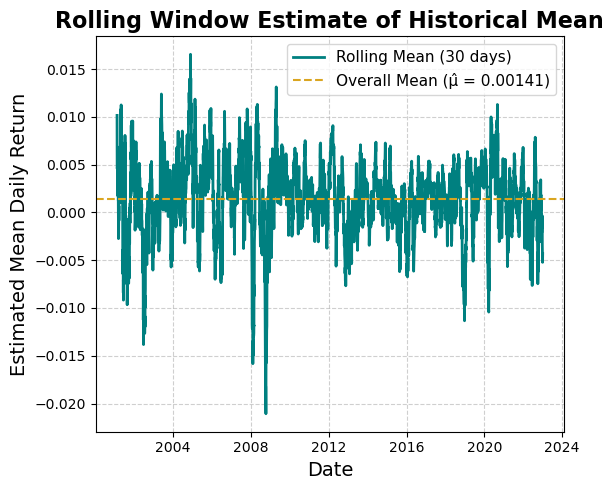

In [3]:
# Calculate daily returns and squared returns
t = np.arange(len(adjusted_close))
N = len(adjusted_close)
mu_list = []

for i in range(N-1):
    mu = (1/(t[i+1] - t[i])) * ((adjusted_close[i+1] - adjusted_close[i]) / adjusted_close[i])
    mu_list.append(mu)

mu_hat = np.sum(mu_list) / N

print("The historical estimator of the mean is given by: ", mu_hat)

mu_series = pd.Series(mu_list, index=data["Adj Close"].index[1:])

rolling_mu = mu_series.rolling(window=30).mean()

plt.figure(figsize=(6, 5))
plt.plot(rolling_mu, color='#008080', linewidth=2, label="Rolling Mean (30 days)")
plt.axhline(mu_hat, color='#daa520', linestyle='--', label=f"Overall Mean (μ̂ = {mu_hat:.5f})")
plt.title("Rolling Window Estimate of Historical Mean", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Estimated Mean Daily Return", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("rolling_mean_estimate.png", dpi=300)
plt.show()

### The estimator for the historical volatility is given by the following formula, obtained from the Assignment 1 notes.

$$
\hat{\sigma}_N^2 
:= \frac{1}{N-1}
\sum_{k=0}^{N-1}
\frac{1}{t_{k+1} - t_k}
\left(
    \frac{S_{t_{k+1}}^M - S_{t_k}^M}{S_{t_k}^M}
    \;-\;
    (t_{k+1} - t_k)\,\hat{\mu}_N
\right)^2
$$

$$
= \frac{1}{N-1}
\sum_{k=0}^{N-1}
\frac{1}{t_{k+1} - t_k}
\Biggl[
    \Bigl(
        \frac{S_{t_{k+1}}^M - S_{t_k}^M}{S_{t_k}^M}
    \Bigr)^2
    \;-\;
    \frac{T}{N-1}\,\hat{\mu}_N^2
\Biggr]
$$

In [4]:
sigma_list = []
for i in range(N-1):
    sigma = (1/(t[i+1] - t[i])) * ((adjusted_close[i+1] - adjusted_close[i]) / adjusted_close[i] - (t[i+1] - t[i])*mu_hat)**2
    sigma_list.append(sigma)

sigma_hat_squared = np.sum(sigma_list) / (N - 1)
sigma_hat = np.sqrt(sigma_hat_squared)
print("The historical estimator of the volatility is given by: ", sigma_hat)


The historical estimator of the volatility is given by:  0.022857490980164128


### The estimator for the Garman-Klass Volatility estimator is given by the following formula:

$$
\sigma_{\mathrm{Garman\text{-}Klass}}
=
\sqrt{
    \frac{1}{2T} 
    \sum_{t=1}^{T}
    \Bigl[
        \ln\!\Bigl(\frac{h_t}{l_t}\Bigr)
    \Bigr]^{2}
    \;-\;
    \frac{2\ln(2) - 1}{T}
    \sum_{t=1}^{T}
    \Bigl[
        \ln\!\Bigl(\frac{c_t}{o_t}\Bigr)
    \Bigr]^{2}
}.
$$


In [5]:
high = data["High"].values
low = data["Low"].values
close = data["Close"].values
open_ = data["Open"].values

T = len(high)

sum_hl = np.sum((np.log(high / low))**2)

sum_co = np.sum((np.log(close / open_))**2)

sigma_gk = np.sqrt(
    (1.0 / (2.0 * T)) * sum_hl
    - (((2.0 * np.log(2)) - 1.0) / T) * sum_co
)

print("The Garman-Klass estimator of the volatility is given by: ", sigma_gk)

The Garman-Klass estimator of the volatility is given by:  0.019465371561795664


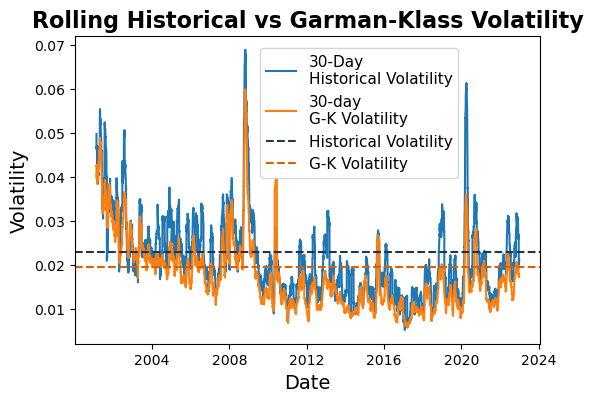

In [ ]:
window = 30
data["Return"] = data["Close"].pct_change()

def calc_rolling_vol(returns, mu_hat):
    # Number of prices in the window
    W = len(returns)
    
    # Number of returns is one less than the number of prices
    N = W - 1  
    if N < 2:
        return np.nan
   
    variance_terms = (returns - mu_hat)**2
    sigma_sq = np.sum(variance_terms) / (N - 1)
    return np.sqrt(sigma_sq)


data["Rolling_Vol"] = data["Return"].rolling(window=window).apply(calc_rolling_vol, args=(mu_hat,), raw=True)


data['HL_Log'] = np.log(data['High'] / data['Low'])**2
data['CO_Log'] = np.log(data['Close'] / data['Open'])**2

# Compute rolling sums for each term
data['Rolling_HL'] = data['HL_Log'].rolling(window=window).sum()
data['Rolling_CO'] = data['CO_Log'].rolling(window=window).sum()

data['GkVol'] = np.sqrt((1 / (2 * window)) * data['Rolling_HL'] - ((2 * np.log(2) - 1) / window) * data['Rolling_CO'])

path = "historical_and_garman_klass_volatility.png"

plt.figure(figsize=(6, 4))
plt.plot(data.index, data["Rolling_Vol"], label='30-Day\nHistorical Volatility', color="#1F77B4")
plt.plot(data.index, data["GkVol"], label='30-day\nG-K Volatility', color='#FF7F0E')
plt.axhline(sigma_hat, color='#1d3557', linestyle='--', label="Historical Volatility")
plt.axhline(sigma_gk, color='#d95f02', linestyle='--', label="G-K Volatility")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.title('Rolling Historical vs Garman-Klass Volatility',fontsize=16, fontweight='bold')
plt.legend(fontsize=11, bbox_to_anchor=(0.38, 0.985), loc='upper left')
plt.savefig(path, dpi=300, bbox_inches='tight')

plt.show()

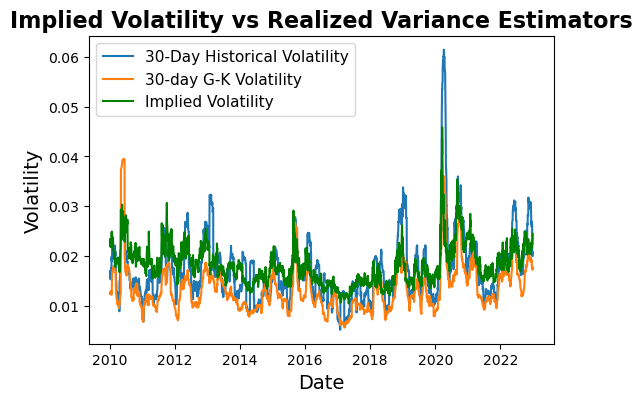

In [7]:
prices = load_sp500_dataset()
# Implied Volatility data from skfolio is only avaialble for 2010-today
implied_vol = load_sp500_implied_vol_dataset()
ticker = "AAPL"
prices_single = prices[[ticker]]
implied_vol_single = implied_vol[[ticker]]
# Rescaled by amount of trading days in a year
implied_vol_single_rescaled = implied_vol_single / np.sqrt(252)

common_dates = data.index.intersection(implied_vol_single_rescaled.index)

data_aligned = data.loc[common_dates]
implied_vol_single_rescaled = implied_vol_single_rescaled.loc[common_dates]

plt.figure(figsize=(6, 4))
plt.plot(data_aligned.index, data_aligned["Rolling_Vol"], label='30-Day Historical Volatility', color="#1F77B4")
plt.plot(data_aligned.index, data_aligned["GkVol"], label='30-day G-K Volatility', color='#FF7F0E')
plt.plot(implied_vol_single.index, implied_vol_single_rescaled, label='Implied Volatility', color='green')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.title('Implied Volatility vs Realized Variance Estimators', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
path = "historical_garman_klass__implied_volatility.png"
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()




In [8]:
spx_symbol = "^SPX"
today_string = "2025-03-05"
today = datetime.datetime.strptime(today_string, "%Y-%m-%d")
end_date = today
start_date = end_date - datetime.timedelta(days=365)
spx_data = yf.download(spx_symbol, start=start_date, end=end_date)

lastBusDay = spx_data.index[-1]
vix_data = yf.download(
    "^VIX", start=lastBusDay, end=lastBusDay + datetime.timedelta(days=1)
)

spx_ticker = yf.Ticker("^SPX")
expiry_date = "2025-04-28"
chain = spx_ticker.option_chain(expiry_date)

calls = pd.read_csv("Call_option_data_2025-04-03_final.csv")
calls = calls.reset_index(drop=True)
calls.drop(columns=["Unnamed: 0"], inplace=True)


puts = pd.read_csv("Put_option_data_2025-04-03_final.csv")
puts = puts.reset_index(drop=True)
puts.drop(columns=["Unnamed: 0"], inplace=True)

# Given by the assignment (CBOE)
tau = 30 / 365

# risk-free interest rate is set equal to US treasury yield for 30-days
r = 0.02
F = np.exp(r * tau) * spx_data["Close"].iloc[-1].values[0]
print(f"Forward Price F: {F}")

puts = puts[(puts["strike"] < F)]
calls = calls[(calls["strike"] > F)] 


# Where the put price is denoted by the average of the bid and ask prices
puts_component = (
    (((puts["bid"] + puts["ask"])/2) * ((1 / puts["strike"]) - (1 / puts["strike"].shift(-1))))
    .dropna()
    .sum()
)

calls_component = (
    (((calls["bid"] + calls["ask"])/2) * ((1 / calls["strike"].shift(1)) - (1 / (calls["strike"]))))
    .dropna()
    .sum()
)
summation = puts_component + calls_component
VIX = np.sqrt((((2 * np.exp(r * tau)) / tau) * summation))
print("VIX:", VIX * 100)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


Forward Price F: 5787.656042075254
VIX: 20.50555555472897


[*********************100%***********************]  1 of 1 completed


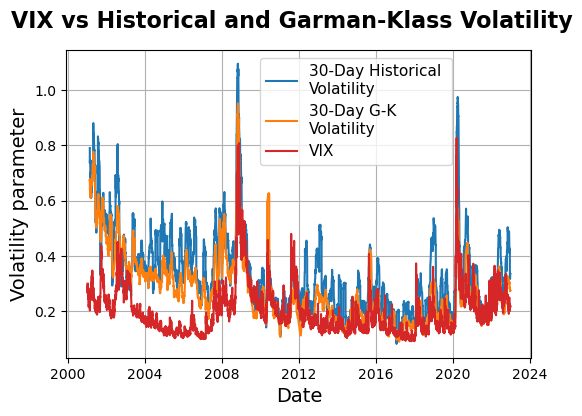

In [9]:
start_date = "2001-01-01"
end_date = "2023-01-01"

vix_data = yf.download(
    "^VIX", start=start_date, end=end_date
)

plt.figure(figsize=(6,4))
plt.plot(data.index, data["Rolling_Vol"] * np.sqrt(252), label='30-Day Historical \nVolatility', color='#1F77B4')
plt.plot(data.index, data["GkVol"] * np.sqrt(252), label='30-Day G-K \nVolatility', color='#FF7F0E')
plt.plot(vix_data.index, vix_data["Close"]/100, label='VIX', color='#D62728')
plt.ylabel("Volatility parameter", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.suptitle("VIX vs Historical and Garman-Klass Volatility", fontsize=16, fontweight='bold')
path = "vix_vs_historical_volatility_difference.png"
plt.grid(True)
plt.legend(bbox_to_anchor=[0.4,0.6], fontsize=11)
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

### Visualization of correlation

In [10]:
def analyze_and_plot_volatility(cleaned_df, vol_col, color, label, filename):
    corr, p_value = stats.pearsonr(cleaned_df["VIX"], cleaned_df[vol_col])
    print(f"\nCorrelation between VIX and {label}: {corr:.3f}")
    alpha = 0.05
    if p_value < alpha:
        print(f"The correlation is statistically significant (p-value: {p_value:.4f})")
    else:
        print(f"The correlation is NOT statistically significant (p-value: {p_value:.4f})")
    
    plt.figure(figsize=(6.5, 5))
    plt.scatter(
        cleaned_df[vol_col],
        cleaned_df["VIX"],
        alpha=0.25,
        s=50,
        color=color,
        edgecolors='w',
        linewidths=0.5,
        label=label
    )
    plt.title(f"VIX vs {label}\nCorr = {corr:.2f}, p = {p_value:.2f}", fontsize=16, weight='bold', pad=20)
    plt.xlabel(label, fontsize=14, labelpad=10)
    plt.ylabel("VIX", fontsize=14, labelpad=10)
    plt.grid(True, linewidth=0.5, linestyle='--', alpha=0.7)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
df = pd.concat([vix_data["Close"], data["Rolling_Vol"], data["GkVol"]], axis=1)
df.columns = ["VIX", "Rolling_Vol", "GkVol"]
cleaned_df = df.dropna().copy()
cleaned_df["VIX"] = cleaned_df["VIX"] / 100


Correlation between VIX and Garman-Klass Volatility: 0.595
The correlation is statistically significant (p-value: 0.0000)


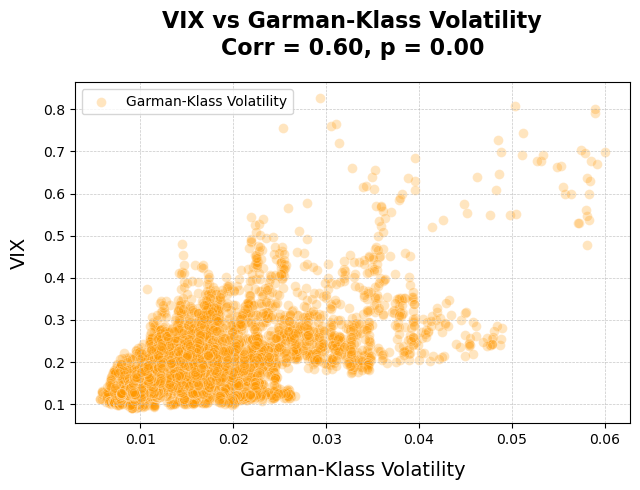


Correlation between VIX and Historical Volatility: 0.576
The correlation is statistically significant (p-value: 0.0000)


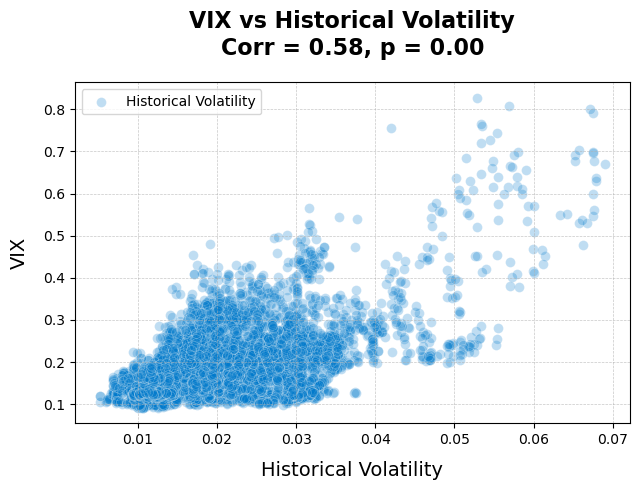

In [12]:
analyze_and_plot_volatility(cleaned_df, "GkVol", "#ff9900", "Garman-Klass Volatility", "vix_vs_gkvol.png")
analyze_and_plot_volatility(cleaned_df, "Rolling_Vol", "#007acc", "Historical Volatility", "vix_vs_hvol.png")

In [13]:
start_date = "2001-01-01"
end_date = "2023-01-01"

spx = yf.download(
    "^SPX", start=start_date, end=end_date
)

spx["Log_Return"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx.dropna(inplace=True)
vix_data["Close"] = vix_data["Close"] / 100
vix = vix_data.dropna().copy()

data_df = spx[["Log_Return"]].join(vix, how="inner")
data_df = data_df.join(data[["Rolling_Vol"]], how="inner")
data_df = data_df[["Log_Return", "Close", "Rolling_Vol"]].dropna().copy()

def run_regression_plot(x_col, x_label, color, label, title, save_name):
    X = sm.add_constant(data_df[x_col])
    y = data_df["Log_Return"]
    model = sm.OLS(y, X).fit()
    print(f"\nResults for regression: SPX log return vs {x_col}")
    print(model.summary())

    x_sorted = np.sort(data_df[x_col])
    X_sorted = sm.add_constant(x_sorted)
    y_pred = model.predict(X_sorted)


    plt.figure(figsize=(6.5, 5))
    plt.scatter(data_df[x_col], y, alpha=0.3, s=50, color=color, edgecolor="w", linewidth=0.5, label=label)
    plt.plot(x_sorted, y_pred, color="darkred", linewidth=2, label="OLS fit")
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel("SPX Daily Log Return", fontsize=14)
    plt.title(title, fontsize=16, weight="bold", pad=15)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.tight_layout()
   
    plt.savefig(f"{save_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

[*********************100%***********************]  1 of 1 completed



Results for regression: SPX log return vs Close
                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     112.9
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           4.04e-26
Time:                        11:24:04   Log-Likelihood:                 16391.
No. Observations:                5505   AIC:                        -3.278e+04
Df Residuals:                    5503   BIC:                        -3.276e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

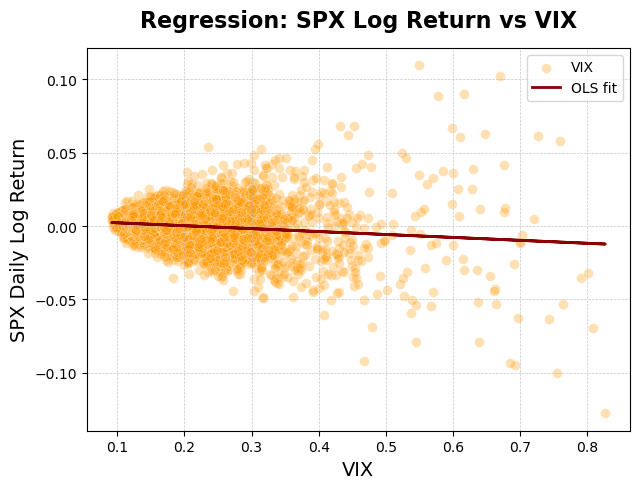


Results for regression: SPX log return vs Rolling_Vol
                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.811
Date:                Fri, 18 Apr 2025   Prob (F-statistic):             0.0510
Time:                        11:24:05   Log-Likelihood:                 16337.
No. Observations:                5505   AIC:                        -3.267e+04
Df Residuals:                    5503   BIC:                        -3.266e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

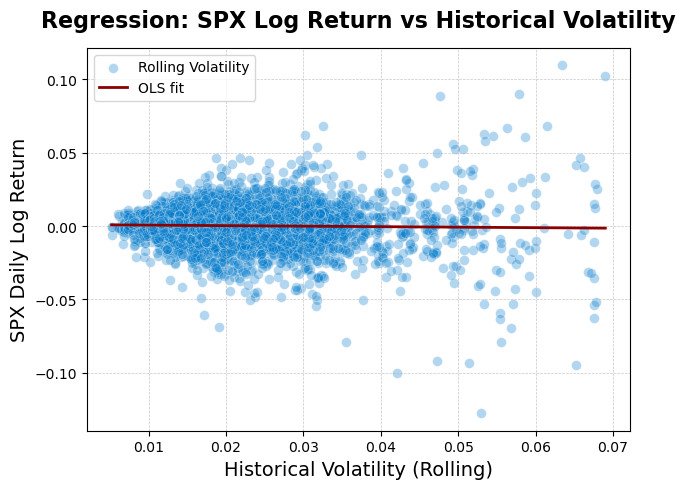

In [14]:
run_regression_plot(
    x_col="Close",
    x_label="VIX",
    color="#ff9900",
    label="VIX",
    title="Regression: SPX Log Return vs VIX",
    save_name="spx_vix"
)
#ff9900
run_regression_plot(
    x_col="Rolling_Vol",
    x_label="Historical Volatility (Rolling)",
    color="#007acc",
    label="Rolling Volatility",
    title="Regression: SPX Log Return vs Historical Volatility",
    save_name="spx_rollingvol"
)